# Visión por computadora con Hugging Face

Así como los modelos basados ​​en Transformers han revolucionado el PLN, ahora vemos una explosión de investigaciones que los aplican a todo tipo de dominios. 

Uno de los más revolucionarios fue el Vision Transformer (ViT), que fue presentado en junio de 2021 por un equipo de investigadores de Google Brain.

Usaremos el `Trainer` de Hugging Face para entrenar nuestro modelo de clasificación de imágenes. 

Pero antes tenemos que proporcionarle información sobre nuestros datos, el procesamiento de los datos, el modelo, las métricas e información del entrenamiento.

En específico necesitamos definir cada uno de estos puntos:

    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor



## Procesando los datos para visión



Usaremos un Dataset del Hub y lo usaremos para afinar un ViT preentrenado con 🤗 `Transformers`.

### Descargando el dataset

Usaremos el dataset [beans](https://huggingface.co/datasets/beans). Con base en una imagen de una hoja de frijol buscamos predecir si la hoja está saludable o si está enferma. El tipo de enfermedad que tiene (Angular Leaf Spot o Bean Rust).

In [ ]:
%%capture
!pip install datasets transformers

In [ ]:
from datasets import load_dataset

ds = load_dataset("beans")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

Dataset beans downloaded and prepared to /root/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1034
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 133
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 128
    })
})

Miremos un ejemplo.

In [ ]:
ex = ds["train"][40]
ex

{'image_file_path': '/root/.cache/huggingface/datasets/downloads/extracted/b0a21163f78769a2cf11f58dfc767fb458fc7cea5c05dccc0144a2c0f0bc1292/train/angular_leaf_spot/angular_leaf_spot_train.134.jpg',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x7FB27348F3D0>,
 'labels': 0}

Como en la key `image` tenemos una imagen tipo PIL entonces podemos verla.

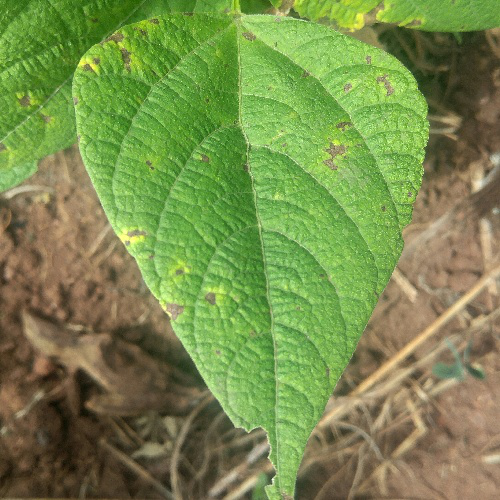

In [ ]:
image = ex["image"]
image

Aprendamos un poco más sobre las etiquetas en nuestro Dataset. Por ejemplo, notamos que tenemos tres etiquetas.

In [ ]:
labels = ds["train"].features["labels"]
labels

ClassLabel(names=['angular_leaf_spot', 'bean_rust', 'healthy'], id=None)

El método `int2str` de una `ClassLabel` nos permite pasar la representación en número (entero) de la etiqueta y recibir el nombre de la clase.

In [ ]:
labels.int2str(ex["labels"])

'angular_leaf_spot'

### Cargando el ViT Feature Extractor

Prepararemos estas imágenes para nuestro modelo.

Cuando se entrenan los modelos ViT se aplican transformaciones específicas a las imágenes que se les alimentan. Si usa las transformaciones incorrectas en su imagen, el modelo no entenderá lo que está viendo. 🖼 ➡️

Para asegurarnos de que aplicamos las transformaciones correctas, usaremos un `ViTFeatureExtractor` inicializado con una configuración que se guardó junto con el modelo pre-entrenado que planeamos usar. En nuestro caso usaremos el modelo `google/vit-base-patch16-224-in21k`, así que carguemos su deacture extractor desde el Hub.

Un extractor de características se encarga de preparar las características de los inputs de un modelo.


In [ ]:
from transformers import ViTFeatureExtractor

repo_id = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(repo_id)

/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Puedes ver la configuración del extractor imprimiéndola.

In [ ]:
print(feature_extractor)

ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}



Para procesar una imagen, simplemente pásala a la función `call` del extractor. Esto devolverá un diccionario que contiene valores de pixeles, que es la representación numérica que se pasará al modelo.

De forma determinada obtenemos una matriz NumPy, pero si agregamos el argumento `return_tensors='pt'`, obtendremos tensores de PyTorch en su lugar.

In [ ]:
feature_extractor(image, return_tensors="pt")

{'pixel_values': tensor([[[[-0.2627, -0.3255, -0.4118,  ..., -0.1843, -0.1608, -0.1608],
          [-0.3255, -0.3176, -0.4353,  ..., -0.1686, -0.1373, -0.1529],
          [-0.3725, -0.3804, -0.4588,  ..., -0.2000, -0.1373, -0.1608],
          ...,
          [-0.3961, -0.4039, -0.3882,  ...,  0.2941,  0.2941,  0.2706],
          [-0.3804, -0.4118, -0.3412,  ...,  0.2471,  0.2627,  0.2784],
          [-0.2314, -0.1922, -0.1529,  ...,  0.2627,  0.2706,  0.2706]],

         [[ 0.1608,  0.0980,  0.0118,  ...,  0.2471,  0.2706,  0.2706],
          [ 0.0980,  0.1059, -0.0118,  ...,  0.2549,  0.2784,  0.2627],
          [ 0.0510,  0.0431, -0.0431,  ...,  0.2157,  0.2627,  0.2392],
          ...,
          [-0.5137, -0.5216, -0.4980,  ...,  0.0588,  0.0588,  0.0353],
          [-0.4902, -0.5216, -0.4510,  ...,  0.0118,  0.0196,  0.0431],
          [-0.3412, -0.3020, -0.2549,  ...,  0.0275,  0.0353,  0.0353]],

         [[-0.5922, -0.6392, -0.7176,  ..., -0.4824, -0.5059, -0.5216],
          [-0

Nos regresa un diccionario con una sola key.

In [ ]:
feature_extractor(image, return_tensors="pt").keys()

dict_keys(['pixel_values'])

Podemos ver la forma del tensor de pixeles.

In [ ]:
feature_extractor(image, return_tensors="pt")["pixel_values"].shape

torch.Size([1, 3, 224, 224])

### Procesando el dataset

Ahora podemos leer imágenes y transformarlas en inputs para nuestro modelo. Escribamos una función que juntará esos dos pasos. Recuerda que `feature_extractor` retorna un diccionario con la key `pixel_values`. Le sumamos una segunda key con las etiquetas `labels`.

In [ ]:
def process_example(example):
  inputs = feature_extractor(example["image"], return_tensors="pt")
  inputs["labels"] = example["labels"]
  return inputs

Así se ve un ejemplo procesado de esta manera.

In [ ]:
process_example(ds["train"][10])

{'pixel_values': tensor([[[[ 0.0275, -0.0196,  0.0196,  ...,  0.0353,  0.2157, -0.0039],
          [-0.0275,  0.0980, -0.0275,  ...,  0.2000,  0.3569,  0.1922],
          [-0.0902,  0.1294,  0.0353,  ...,  0.1686,  0.3333,  0.3098],
          ...,
          [-0.0196, -0.2784, -0.4353,  ..., -0.2863, -0.1922, -0.3882],
          [ 0.2392, -0.1686, -0.3804,  ..., -0.1294, -0.1608, -0.3647],
          [ 0.3176, -0.0275, -0.3255,  ..., -0.2392, -0.1686, -0.3412]],

         [[-0.3412, -0.3569, -0.2627,  ..., -0.3176, -0.1373, -0.3412],
          [-0.4039, -0.2627, -0.3333,  ..., -0.1373, -0.0118, -0.1843],
          [-0.4745, -0.2314, -0.2941,  ..., -0.2000, -0.0275, -0.0510],
          ...,
          [ 0.2000,  0.0431, -0.0118,  ..., -0.5373, -0.3569, -0.5216],
          [ 0.3333,  0.0745,  0.0118,  ..., -0.4039, -0.3490, -0.4902],
          [ 0.3647,  0.1922,  0.0588,  ..., -0.5137, -0.3647, -0.4667]],

         [[-0.4980, -0.5294, -0.4745,  ..., -0.4353, -0.2784, -0.4745],
          [-0

Podemos llamar a la función `map` y aplicar esto a todos los ejemplos a la vez. Pero esto puede ser muy lento, especialmente si usa un dataset más grande. 

Entonces podemos aplicar una ***transformación*** al dataset. Las transformaciones solo se aplican a los ejemplos a medida que los indexamos.

Sin embargo, primero deberá actualizar la última función para aceptar un batch posiblemente con más de una imagen, ya que eso es lo que espera `ds.with_transform`.

In [ ]:
def transform(example_batch):
  inputs = feature_extractor([x for x in example_batch["image"]], return_tensors="pt")

  inputs["labels"] = example_batch["labels"]
  return inputs

Puedes aplicar esto directamente al dataset mediante `ds.with_transform(transform)`

In [ ]:
prepared_ds = ds.with_transform(transform)

Ahora, cada vez que obtengas un ejemplo del dataset, la transformación se aplicará en tiempo real.

In [ ]:
prepared_ds["train"][0:2]

{'pixel_values': tensor([[[[-0.5686, -0.5686, -0.5608,  ..., -0.0275,  0.1922, -0.2549],
          [-0.6078, -0.6000, -0.5843,  ..., -0.0353, -0.0196, -0.2706],
          [-0.6314, -0.6314, -0.6157,  ..., -0.2392, -0.3647, -0.2314],
          ...,
          [-0.5373, -0.5529, -0.5765,  ..., -0.0745, -0.0431, -0.0980],
          [-0.5608, -0.5765, -0.5843,  ...,  0.3176,  0.1608,  0.1294],
          [-0.5843, -0.5922, -0.6078,  ...,  0.2784,  0.1451,  0.2000]],

         [[-0.7098, -0.7098, -0.7490,  ..., -0.3725, -0.1608, -0.6000],
          [-0.7333, -0.7333, -0.7569,  ..., -0.3569, -0.3176, -0.5608],
          [-0.7490, -0.7490, -0.7647,  ..., -0.5373, -0.6627, -0.5373],
          ...,
          [-0.7725, -0.7882, -0.8196,  ..., -0.2314, -0.0353,  0.0824],
          [-0.7961, -0.8118, -0.8118,  ...,  0.1843,  0.3176,  0.3725],
          [-0.8196, -0.8196, -0.8275,  ...,  0.0745,  0.2863,  0.3961]],

         [[-0.9922, -0.9922, -1.0000,  ..., -0.5451, -0.3647, -0.7333],
          [-0

El tensor `pixel_values` ​​resultante tendrá forma (2, 3, 224, 224) porque pasamos un batch de dos ejemplos.

### Definiendo el data collator


Los data collators, o recopiladores de datos, son objetos que forman batches utilizando una lista de ejemplos de nuestros datasets. Para poder generar los batches, los data collators pueden aplicar algún procesamiento (como padding en los ejemplos con texto).

Definimos una función, `collate_fn`, que fungirá como nuestro data collator. Devolverá un diccionario por cada batch. Recibirá un batch de datos que luego serán procesadas.

Los batches llegan como listas de dicts. Cada dict tiene los `label` y `pixel_values` de sus respectivos ejemplos, por lo que puedes simplemente desempaquetarlos y apilarlos en tensores de batches. `torch.stack` nos permite concatenar (pegar) tensores.


In [ ]:
import torch

def collate_fn(batch):
  return {
      "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
      "labels": torch.tensor([x["labels"] for x in batch])
  }

## Entrenamiento y evaluación

Definamos el resto de los argumentos necesarios para `Trainer`.

### Definiendo la métrica 

De la biblioteca `Datasets` también podemos cargar métricas. `accuracy` se puede usar fácilmente para comparar las predicciones con las etiquetas originales.

In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(prediction):
  return metric.compute(predictions=np.argmax(prediction.predictions, axis=1), references=prediction.label_ids)


<ipython-input-19-18a1ea23510f>:4: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


### Configurando `Trainer`

Carguemos el modelo preentrenado. Agregaremos `num_labels` para que el modelo cree un encabezado de clasificación con el número correcto de etiquetas. También incluiremos las asignaciones `id2label` y `label2id` para tener etiquetas legibles por humanos en el widget del Hub.

In [ ]:
from transformers import ViTForImageClassification

labels = ds["train"].features["labels"].names

model = ViTForImageClassification.from_pretrained(
    repo_id,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i,c in enumerate(labels)}
)


Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Lo último que se necesita antes de eso es establecer la configuración de entrenamiento definiendo `TrainingArguments`.

La mayoría de estos se explican por sí mismos, pero uno que es bastante importante aquí es `remove_unused_columns=False`. Este eliminará cualquier función que no utilice la función de llamada del modelo. De forma predeterminada es True porque, por lo general, es ideal eliminar las columnas de funciones no utilizadas, lo que facilita el desempaquetado de las entradas en la función de llamada del modelo. Pero, en nuestro caso, necesitamos las funciones no utilizadas ('imagen' en particular) para crear '`pixel_values`'.

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./huggingface.co/EugenioRoma/vit_model",
    evaluation_strategy="steps",
    num_train_epochs=4,
    learning_rate=2e-4,
    remove_unused_columns=False,
    push_to_hub=True,
    load_best_model_at_end=True,
)

Pasemos todo a `Trainer`.

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) y
Token is valid.
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as d

Finalmente, definamos nuestro `Trainer`.

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_ds["train"],
    eval_dataset=prepared_ds["validation"],
    tokenizer=feature_extractor
)

Cloning https://huggingface.co/EugenioRoma/vit_model into local empty directory.


### Entrenamiento

In [ ]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
500,0.134000,0.085494,0.984962


Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/327M [00:00<?, ?B/s]

Upload file runs/Apr04_23-30-46_c17fa18148b5/events.out.tfevents.1680651055.c17fa18148b5.2273.0:   0%|        …

To https://huggingface.co/EugenioRoma/vit_model
   c779092..a702065  main -> main

   c779092..a702065  main -> main

To https://huggingface.co/EugenioRoma/vit_model
   a702065..1701f21  main -> main

   a702065..1701f21  main -> main



***** train metrics *****
  epoch                    =         4.0
  total_flos               = 298497957GF
  train_loss               =      0.1291
  train_runtime            =  0:03:43.92
  train_samples_per_second =       18.47
  train_steps_per_second   =       2.322


### Evaluación

In [ ]:
metrics = trainer.evaluate(prepared_ds["validation"])
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        4.0
  eval_accuracy           =      0.985
  eval_loss               =     0.0855
  eval_runtime            = 0:00:04.04
  eval_samples_per_second =     32.855
  eval_steps_per_second   =      4.199


### Compartimos en el Hub

In [ ]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": "beans",
    "tags": ["image-classification"]
}

trainer.push_to_hub(commit_message="Lo logramos de nuevo equipo Platzi! 🤗", **kwargs)

Upload file runs/Apr04_23-30-46_c17fa18148b5/events.out.tfevents.1680651368.c17fa18148b5.2273.2: 100%|########…

To https://huggingface.co/EugenioRoma/vit_model
   1701f21..6355e1a  main -> main

   1701f21..6355e1a  main -> main

To https://huggingface.co/EugenioRoma/vit_model
   6355e1a..896f823  main -> main

   6355e1a..896f823  main -> main



'https://huggingface.co/EugenioRoma/vit_model/commit/6355e1a866eb24529f8ffcc8d93f2fff07d390eb'